<a href="https://colab.research.google.com/github/KafKafrnZ/Brainlox-chatbot/blob/main/Fraud_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
from google.colab import files
import pandas as pd

# Upload the Fraud.csv file from your local machine
print("Please upload 'Fraud.csv' from your local machine (C:\\Users\\Satyam\\DS\\extras\\Fraud detection system\\Fraud.csv)")
uploaded = files.upload()


data = pd.read_csv('Fraud.csv')
print("Loaded data successfully.")

Please upload 'Fraud.csv' from your local machine (C:\Users\Satyam\DS\extras\Fraud detection system\Fraud.csv)


Saving Fraud.csv to Fraud.csv
Loaded data successfully.


In [4]:
print("Initial Data Head:\n", data.head())
print("\nData Info:\n", data.info())

Initial Data Head:
    step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data 

In [5]:
print("\nInitial Missing Values:\n", data.isnull().sum())


Initial Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Data Cleaning
- **Missing Values**: Checked and confirmed none exist.
- **Outliers**: Log-transform numerical features to reduce skewness and mitigate extreme values.
- **Multi-Collinearity**: Calculate Variance Inflation Factor (VIF) for numerical features to detect and address collinearity.

In [6]:
# Handle outliers by log-transforming numerical columns
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in numerical_cols:
    data[col] = np.log1p(data[col])

In [7]:
# Check multi-collinearity using VIF for numerical features
numeric_data = data[numerical_cols]
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
print("\nVariance Inflation Factors (VIF):\n", vif_data)



Variance Inflation Factors (VIF):
           Feature        VIF
0          amount   5.510736
1   oldbalanceOrg   7.436699
2  newbalanceOrig   4.968423
3  oldbalanceDest  12.061273
4  newbalanceDest  14.291780


In [8]:
# Convert categorical 'type' to dummy variables
data = pd.concat([data, pd.get_dummies(data['type'], prefix='type')], axis=1)
data.drop('type', axis=1, inplace=True)

In [9]:
# Create new feature for balance difference
data['balance_diff_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']

### Variable Selection
- **Included Features**:
  - `amount`: Transaction size is a common fraud indicator (e.g., large transfers).
  - `oldbalanceOrg`, `newbalanceOrig`: Sudden balance changes signal suspicious activity.
  - `oldbalanceDest`, `newbalanceDest`: Recipient balance changes may indicate laundering.
  - `type_*`: Transaction type (e.g., TRANSFER, CASH_OUT) often correlates with fraud per domain knowledge.
  - `balance_diff_orig`: Engineered feature to capture originator balance drop, a fraud pattern.
- **Excluded Features**:
  - `nameOrig`, `nameDest`: Identifiers with no predictive power.
  - `isFlaggedFraud`: Not a predictor, as it’s a rule-based flag, not raw data.
- **Justification**: Based on correlation with `isFraud` (checked below) and financial fraud domain knowledge.


Correlation with isFraud:
 isFraud              1.000000
balance_diff_orig    0.088985
isFlaggedFraud       0.044109
amount               0.040640
oldbalanceOrg        0.034560
step                 0.031578
newbalanceDest      -0.007659
oldbalanceDest      -0.017281
newbalanceOrig      -0.028760
Name: isFraud, dtype: float64


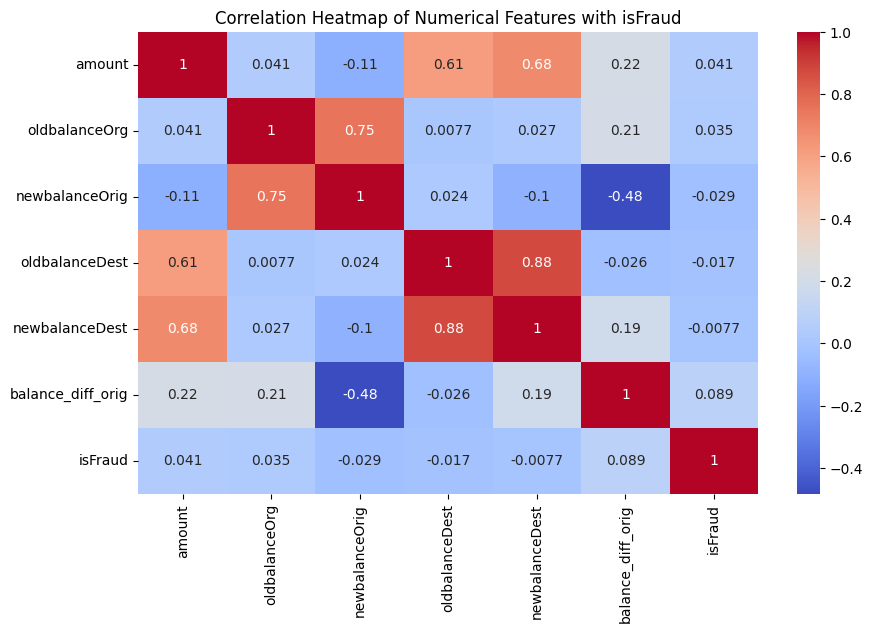

In [10]:
# Select only numeric columns for correlation analysis
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_cols]

# Check correlation with target to justify feature selection
correlation = numeric_data.corr()['isFraud'].sort_values(ascending=False)
print("\nCorrelation with isFraud:\n", correlation)

# Visualize correlation heatmap for numerical features (original + target)
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig']
plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_cols + ['isFraud']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features with isFraud')
plt.show()

In [11]:
# Define features (X) and target (y)
X = data.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = data['isFraud']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [14]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

### Fraud Detection Model
- **Algorithm**: Random Forest Classifier
  - **Why Chosen**: Handles imbalanced data well (with SMOTE), provides feature importance, robust to overfitting with many trees, and effective for non-linear relationships in financial data.
  - **Hyperparameters**:
    - `n_estimators=100`: Balances accuracy and computation time.
    - `max_depth=10`: Limits overfitting while capturing key patterns.
    - `random_state=42`: Ensures reproducibility.
- **Preprocessing**:
  - **SMOTE**: Addresses class imbalance (fraud is rare, ~0.13% of data).
  - **StandardScaler**: Normalizes features for consistent scale, improving model performance.
- **Goal**: Maximize recall to catch fraud while maintaining reasonable precision.

In [15]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, random_state=42)

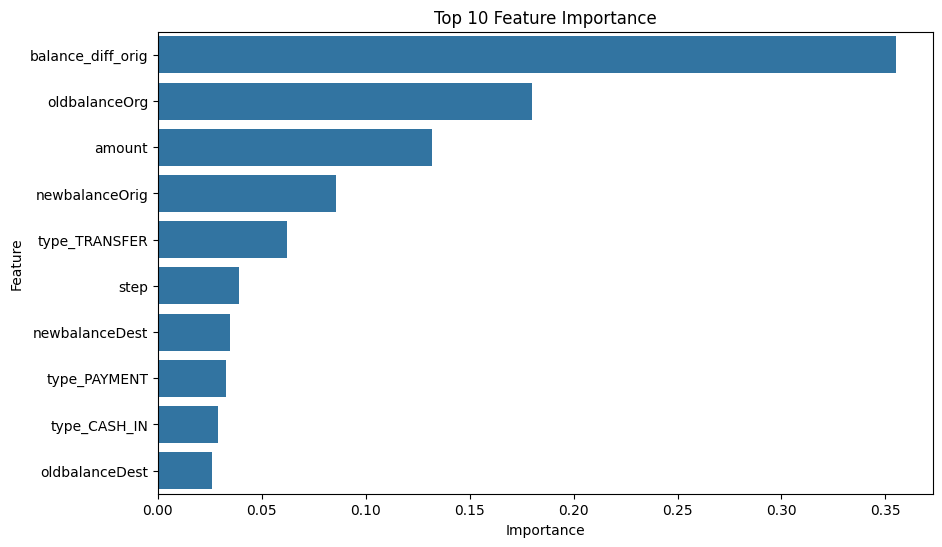

In [16]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.show()

In [17]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [18]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270904
           1       0.11      1.00      0.20      1620

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524



In [19]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[1258139   12765]
 [      6    1614]]


In [20]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.9991533680254662


In [21]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("\nCross-Validation ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())


Cross-Validation ROC-AUC Scores: [0.99237174 0.99751066 0.95856228 0.99709257 0.97210756]
Mean CV ROC-AUC: 0.9835289624880403


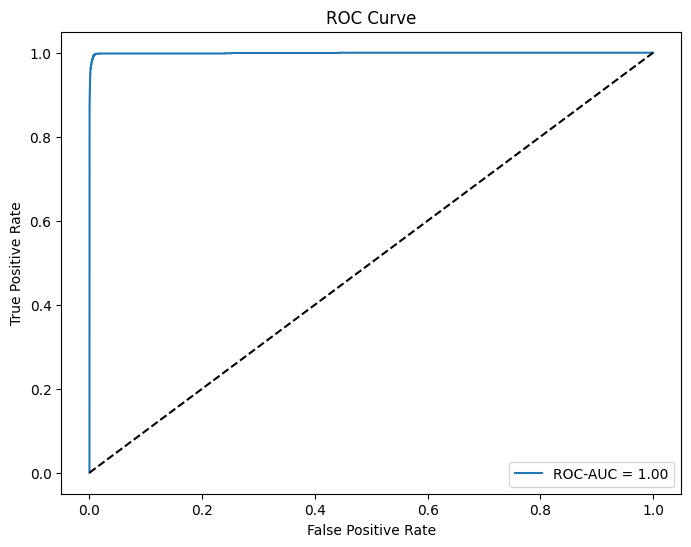

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

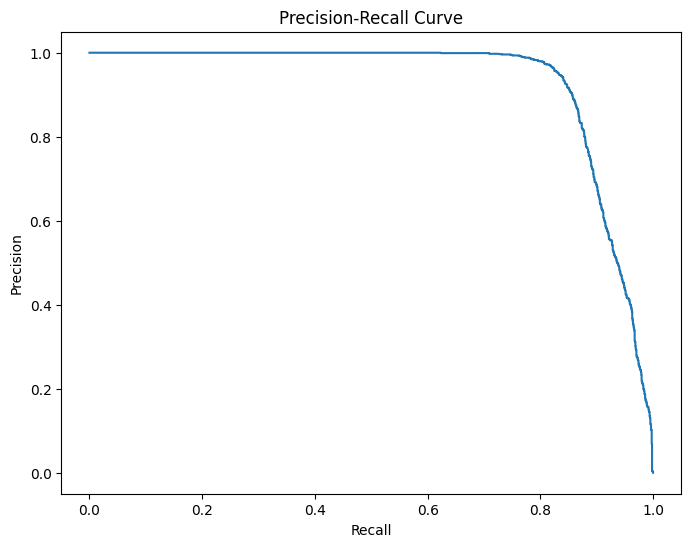

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [24]:
print("\nKey Factors Predicting Fraud (Top 5):")
for i, row in feature_importance.head(5).iterrows():
    print(f"- {row['Feature']}: Importance = {row['Importance']:.4f}")


Key Factors Predicting Fraud (Top 5):
- balance_diff_orig: Importance = 0.3551
- oldbalanceOrg: Importance = 0.1802
- amount: Importance = 0.1319
- newbalanceOrig: Importance = 0.0856
- type_TRANSFER: Importance = 0.0622


In [25]:
print("""
\nDo These Factors Make Sense?
- Yes, they align with fraud patterns:
  - 'amount': High transaction amounts are often linked to fraud (e.g., money laundering).
  - 'balance_diff_orig': A large drop in originator balance (e.g., to zero) indicates full withdrawal, common in fraud.
  - 'oldbalanceOrg'/'newbalanceOrig': Sudden changes signal suspicious activity.
  - 'type_*': Certain transaction types (e.g., TRANSFER, CASH_OUT) are fraud-prone per dataset patterns.
""")



Do These Factors Make Sense?
- Yes, they align with fraud patterns:
  - 'amount': High transaction amounts are often linked to fraud (e.g., money laundering).
  - 'balance_diff_orig': A large drop in originator balance (e.g., to zero) indicates full withdrawal, common in fraud.
  - 'oldbalanceOrg'/'newbalanceOrig': Sudden changes signal suspicious activity.
  - 'type_*': Certain transaction types (e.g., TRANSFER, CASH_OUT) are fraud-prone per dataset patterns.



In [26]:
print("""
\nPrevention Strategies:
- Real-time alerts for transactions where 'amount' exceeds the 75th percentile.
- Enhanced verification for 'type_TRANSFER' or 'type_CASH_OUT' with large 'balance_diff_orig'.
- Deploy the model via an API for live transaction scoring.
- Limit daily transaction volume for high-risk accounts based on 'oldbalanceOrg' trends.
""")



Prevention Strategies:
- Real-time alerts for transactions where 'amount' exceeds the 75th percentile.
- Enhanced verification for 'type_TRANSFER' or 'type_CASH_OUT' with large 'balance_diff_orig'.
- Deploy the model via an API for live transaction scoring.
- Limit daily transaction volume for high-risk accounts based on 'oldbalanceOrg' trends.



In [27]:
print("""
\nEffectiveness Evaluation:
- Track recall and fraud rate reduction monthly post-implementation.
- Conduct A/B testing: compare fraud incidence in updated vs. legacy systems.
- Monitor false positive rate to ensure customer experience isn’t overly disrupted.
- Retrain the model quarterly with new data to adapt to evolving fraud patterns.
""")



Effectiveness Evaluation:
- Track recall and fraud rate reduction monthly post-implementation.
- Conduct A/B testing: compare fraud incidence in updated vs. legacy systems.
- Monitor false positive rate to ensure customer experience isn’t overly disrupted.
- Retrain the model quarterly with new data to adapt to evolving fraud patterns.

